In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import fsolve
import scipy.stats as stats

In [2]:
df = pd.read_csv('drie_profielen.csv')
# Bekijk even de eerste rijen; bijvoorbeeld:
print("Eerste rijen (inclusief de oorspronkelijke header):")
df = df.iloc[:, 1:]
print(df.head())

Eerste rijen (inclusief de oorspronkelijke header):
        1       9       19
0  1.1375  1.7650  22.2475
1  1.2500  1.7150   4.6850
2  0.6750  1.6125  25.6775
3  0.8250  1.6125  29.0300
4  1.1750  1.6650  10.2625


In [3]:
df.columns = ['meter1', 'meter2', 'meter3']
df

,meter1,meter2,meter3
0,1.1375,1.7650,22.2475
1,1.2500,1.7150,4.6850
2,0.6750,1.6125,25.6775
3,0.8250,1.6125,29.0300
4,1.1750,1.6650,10.2625
...,...,...,...
35035,1.6500,1.6325,28.7300
35036,1.8125,1.5825,28.6175
35037,1.1375,1.6325,28.8425
35038,1.5375,1.6325,28.8050


In [4]:
timestamps = pd.date_range(start='2014-01-01 00:00', end='2014-12-31 23:45', freq='15min')
print("Aantal tijdstempels:", len(timestamps))
print("Aantal rijen in data:", len(df))

Aantal tijdstempels: 35040
Aantal rijen in data: 35040


In [5]:
df.insert(0, 'timestamp', timestamps)

In [6]:
df

,timestamp,meter1,meter2,meter3
0,2014-01-01 00:00:00,1.1375,1.7650,22.2475
1,2014-01-01 00:15:00,1.2500,1.7150,4.6850
2,2014-01-01 00:30:00,0.6750,1.6125,25.6775
3,2014-01-01 00:45:00,0.8250,1.6125,29.0300
4,2014-01-01 01:00:00,1.1750,1.6650,10.2625
...,...,...,...,...
35035,2014-12-31 22:45:00,1.6500,1.6325,28.7300
35036,2014-12-31 23:00:00,1.8125,1.5825,28.6175
35037,2014-12-31 23:15:00,1.1375,1.6325,28.8425
35038,2014-12-31 23:30:00,1.5375,1.6325,28.8050


# Formuleer een aantal vragen/hypotheses waaraan je a.d.h.v. het samengevoegde bestand zou kunnen beantwoorden.

- Zijn er significante verschillen in het energieverbruik tussen de verschillende meters?
- Hoe verhoudt het energieverbruik zich tussen de verschillende seizoenen?
- Is er een trend zichtbaar in het energieverbruik over het hele jaar?

# Bepaal Spreiding van de drie verbruiksprofielen a.d.h.v. boxplot

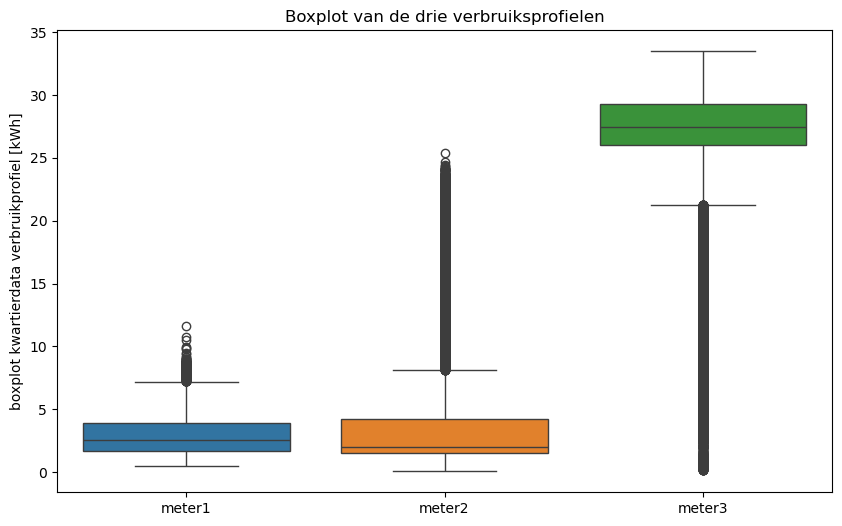

In [7]:
# 3.1 Spreiding van de verbruiksprofielen: Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['meter1', 'meter2', 'meter3']])
plt.title('Boxplot van de drie verbruiksprofielen')
plt.ylabel('boxplot kwartierdata verbruikprofiel [kWh]')
plt.show()


# Baseline in elke verbruiksprofiel

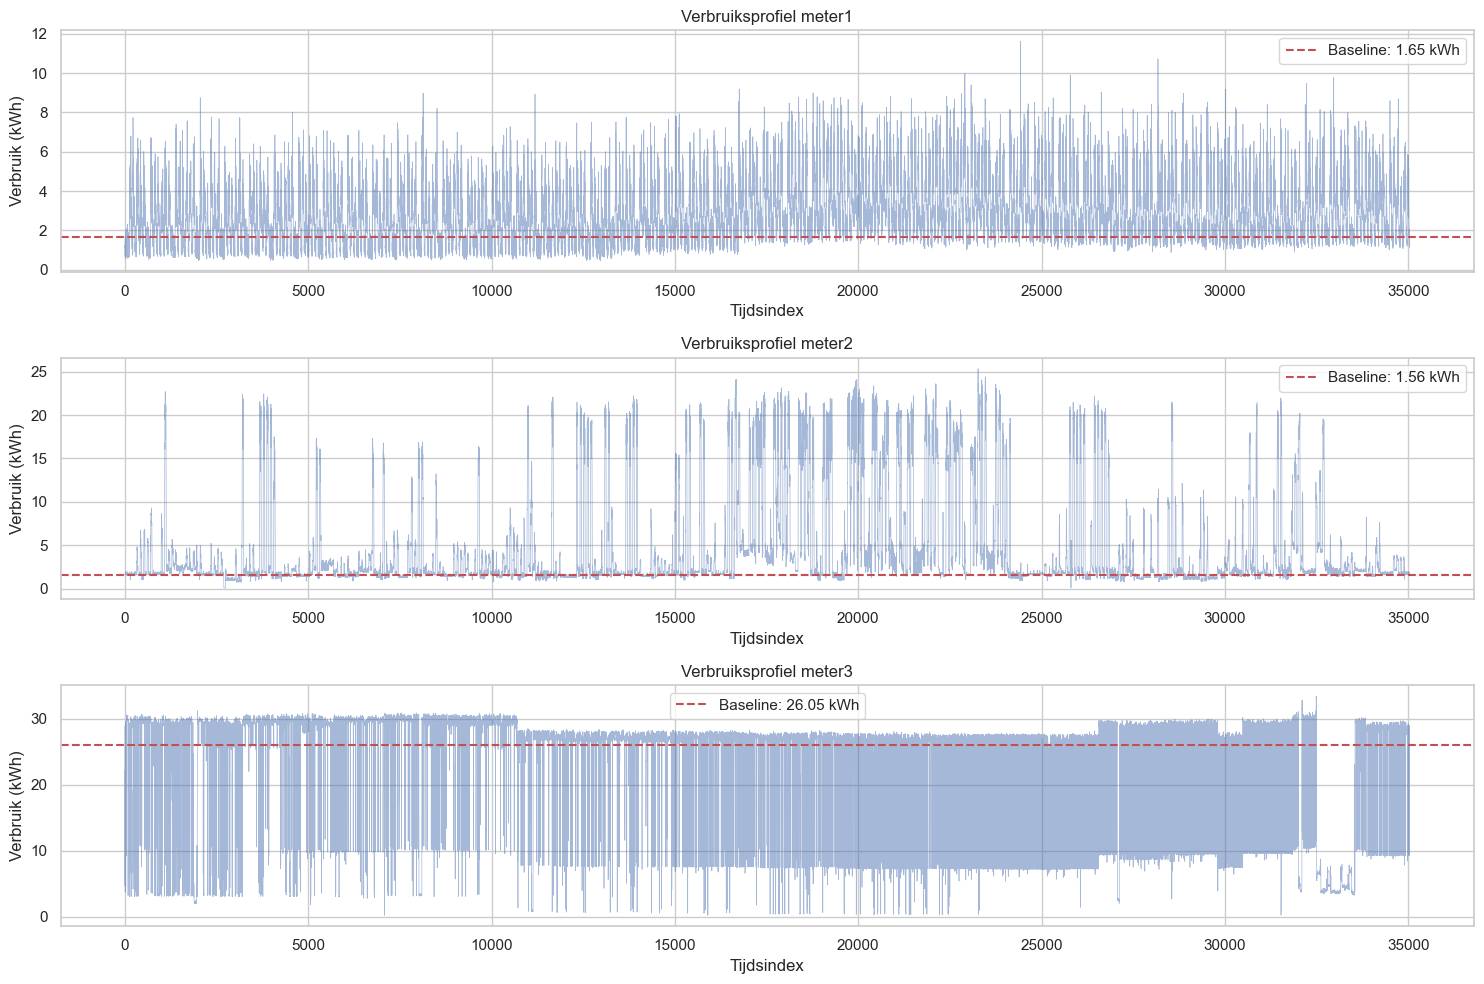


Samenvatting:
        Baseline (kWh)  Meest voorkomende waarde (kWh)  Aantal uitschieters
meter1          1.6500                            1.58                296.0
meter2          1.5625                            1.68               5919.0
meter3         26.0525                           27.18               7003.0


In [8]:
# Functies voor berekeningen
def calculate_baseline(series):
    Q1 = series.quantile(0.25)
    return Q1  # Gebruik Q1 als baseline

def count_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return len(outliers)

# Data inladen
df = pd.read_csv('drie_profielen.csv').iloc[:, 1:]
df.columns = ['meter1', 'meter2', 'meter3']

# Bereken baselines
baselines = {meter: calculate_baseline(df[meter]) for meter in df.columns}

# Plotinstellingen
plt.figure(figsize=(15, 10))
sns.set(style="whitegrid")

# Plot voor elk verbruiksprofiel
for i, meter in enumerate(df.columns, 1):
    plt.subplot(3, 1, i)
    
    # Plot tijdreeks
    sns.lineplot(data=df[meter], linewidth=0.5, alpha=0.5)
    
    # Baseline lijn
    plt.axhline(y=baselines[meter], color='r', linestyle='--', 
                label=f'Baseline: {baselines[meter]:.2f} kWh')
    
    # Stijl
    plt.title(f'Verbruiksprofiel {meter}', fontsize=12)
    plt.ylabel('Verbruik (kWh)')
    plt.xlabel('Tijdsindex')
    plt.legend()
    plt.tight_layout()

plt.show()

# Resultaten tabel
results = {}
for meter in df.columns:
    results[meter] = {
        'Baseline (kWh)': baselines[meter],
        'Meest voorkomende waarde (kWh)': df[meter].round(2).mode()[0],
        'Aantal uitschieters': count_outliers(df[meter])
    }

results_df = pd.DataFrame(results).T
print("\nSamenvatting:")
print(results_df)

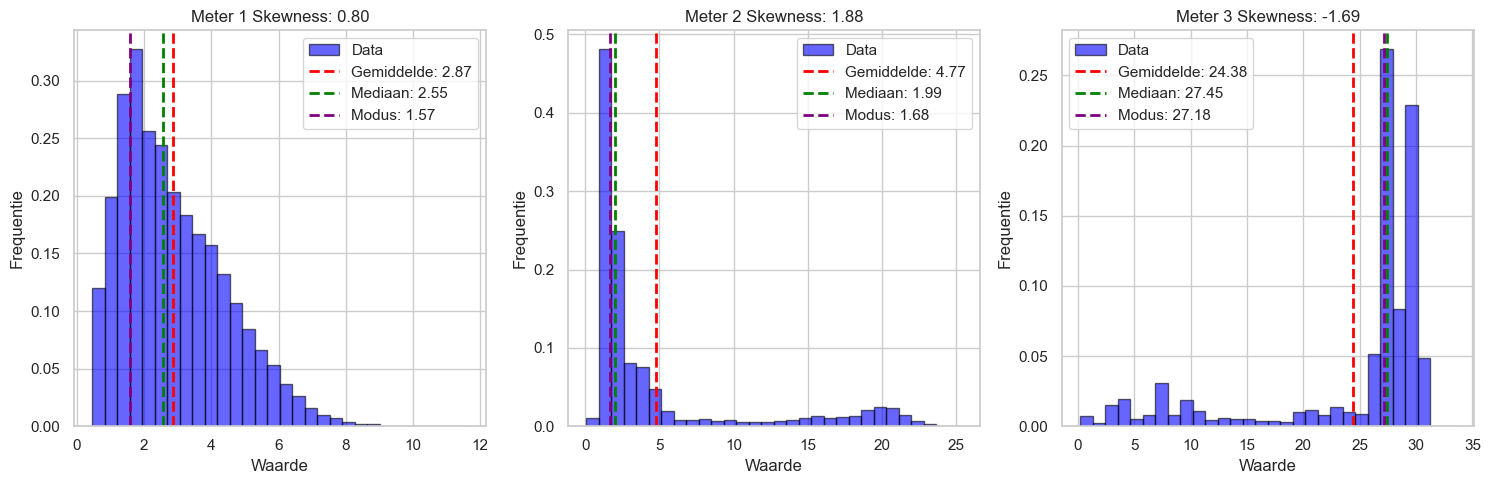

In [9]:
profielen = {"Meter 1": df['meter1'], "Meter 2": df['meter2'], "Meter 3": df['meter3']}

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (label, data) in enumerate(profielen.items()):
    # Berekeningen
    mean = np.mean(data)
    median = np.median(data)
    mode = stats.mode(data, keepdims=True)[0][0]  # Modus
    
    # Skewness berekenen
    skewness = stats.skew(data)
    
    # Histogram plotten
    axes[i].hist(data, bins=30, alpha=0.6, color="blue", edgecolor="black", density=True, label="Data")
    axes[i].axvline(mean, color="red", linestyle="dashed", linewidth=2, label=f"Gemiddelde: {mean:.2f}")
    axes[i].axvline(median, color="green", linestyle="dashed", linewidth=2, label=f"Mediaan: {median:.2f}")
    axes[i].axvline(mode, color="purple", linestyle="dashed", linewidth=2, label=f"Modus: {mode:.2f}")
    
    # Titel en labels
    axes[i].set_title(f"{label} Skewness: {skewness:.2f}")
    axes[i].set_xlabel("Waarde")
    axes[i].set_ylabel("Frequentie")
    axes[i].legend()

plt.tight_layout()
plt.show()


## mediaan

In [10]:
median = df[['meter1', 'meter2', 'meter3']].median()
print("mediaan")
print(median)

mediaan
meter1     2.5500
meter2     1.9850
meter3    27.4475
dtype: float64


In [11]:
# minimale waarde baseline
min_values = df[['meter1', 'meter2', 'meter3']].min()
print("\nMinimale waarde per meter (alternatieve baseline):")
print(min_values)


Minimale waarde per meter (alternatieve baseline):
meter1    0.4625
meter2    0.0750
meter3    0.2000
dtype: float64


## Modus

In [12]:
modes = {}
for col in ['meter1', 'meter2', 'meter3']:
    # rounded = df[col].round(1)
    mode_value = df[col].mode()  # Dit geeft één of meerdere waarden terug indien er meerdere modi zijn.
    modes[col] = mode_value.values
    print(f"\nMeest voorkomende waarde(s) voor {col}: {mode_value.values}")


Meest voorkomende waarde(s) voor meter1: [1.575]

Meest voorkomende waarde(s) voor meter2: [1.6825]

Meest voorkomende waarde(s) voor meter3: [27.185]


## 2. Is er een correlatie van verbruik met weervariabelen?  VEronderstel dat de verbruiksprofielen tussen 1 jan 0:00 en 31 dec 23:45 van 2014 in Brussel zijn

In [13]:
dfweather = pd.read_csv('./POWER_Point_Hourly_20140101_20141231_050d85N_004d39E_LST.csv',delimiter=',')

In [14]:
dfweather

,YEAR,MO,DY,HR,T2M,RH2M,ALLSKY_SFC_SW_DWN,WS10M
0,2014,1,1,0,4.40,94.18,0.0,6.76
1,2014,1,1,1,4.77,94.40,0.0,6.59
2,2014,1,1,2,4.71,93.88,0.0,6.35
3,2014,1,1,3,4.28,94.43,0.0,6.27
4,2014,1,1,4,4.09,94.33,0.0,6.68
...,...,...,...,...,...,...,...,...
8755,2014,12,31,19,0.41,100.00,0.0,3.53
8756,2014,12,31,20,0.66,98.82,0.0,3.92
8757,2014,12,31,21,0.79,97.90,0.0,4.23
8758,2014,12,31,22,0.64,97.69,0.0,4.36


In [15]:
# Creëer een datetime kolom
dfweather['datetime'] = pd.to_datetime(
    dfweather[['YEAR', 'MO', 'DY', 'HR']].rename(columns={'MO': 'month', 'DY': 'day', 'HR': 'hour'}),
    format='%Y-%m-%d %H:%M:%S'
)

# Toon het resultaat
print(dfweather[['YEAR', 'MO', 'DY', 'HR', 'datetime']].head())

   YEAR  MO  DY  HR            datetime
0  2014   1   1   0 2014-01-01 00:00:00
1  2014   1   1   1 2014-01-01 01:00:00
2  2014   1   1   2 2014-01-01 02:00:00
3  2014   1   1   3 2014-01-01 03:00:00
4  2014   1   1   4 2014-01-01 04:00:00


In [16]:
timestamps = pd.date_range(start='2014-01-01 00:00', end='2014-12-31 23:45', freq='15min')
print("Aantal tijdstempels:", len(timestamps))
print("Aantal rijen in data:", len(df))

Aantal tijdstempels: 35040
Aantal rijen in data: 35040


In [17]:
df.insert(0, 'timestamp', timestamps)
df

,timestamp,meter1,meter2,meter3
0,2014-01-01 00:00:00,1.1375,1.7650,22.2475
1,2014-01-01 00:15:00,1.2500,1.7150,4.6850
2,2014-01-01 00:30:00,0.6750,1.6125,25.6775
3,2014-01-01 00:45:00,0.8250,1.6125,29.0300
4,2014-01-01 01:00:00,1.1750,1.6650,10.2625
...,...,...,...,...
35035,2014-12-31 22:45:00,1.6500,1.6325,28.7300
35036,2014-12-31 23:00:00,1.8125,1.5825,28.6175
35037,2014-12-31 23:15:00,1.1375,1.6325,28.8425
35038,2014-12-31 23:30:00,1.5375,1.6325,28.8050


In [18]:
# Converteer de timestamp naar datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Zet de timestamp als index voor resampling
df = df.set_index("timestamp")
df

,meter1,meter2,meter3
timestamp,,,
2014-01-01 00:00:00,1.1375,1.7650,22.2475
2014-01-01 00:15:00,1.2500,1.7150,4.6850
2014-01-01 00:30:00,0.6750,1.6125,25.6775
2014-01-01 00:45:00,0.8250,1.6125,29.0300
2014-01-01 01:00:00,1.1750,1.6650,10.2625
...,...,...,...
2014-12-31 22:45:00,1.6500,1.6325,28.7300
2014-12-31 23:00:00,1.8125,1.5825,28.6175
2014-12-31 23:15:00,1.1375,1.6325,28.8425


In [19]:
# Aggregeer per uur (gemiddelde van de 4 kwartieren)
df_hourly = df.resample("H").mean().reset_index()

# Of: Aggregeer per uur (som van de 4 kwartieren)
# df_hourly = df.resample("H").sum().reset_index()

# Hernoem de kolom voor merging
df_hourly = df_hourly.rename(columns={"timestamp": "datetime"})
df_hourly

C:\Users\vando\AppData\Local\Temp\ipykernel_25388\1935893432.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample("H").mean().reset_index()


,datetime,meter1,meter2,meter3
0,2014-01-01 00:00:00,0.971875,1.676250,20.410000
1,2014-01-01 01:00:00,1.406250,1.613125,11.186250
2,2014-01-01 02:00:00,1.000000,1.651250,28.088750
3,2014-01-01 03:00:00,1.303125,1.612500,29.501875
4,2014-01-01 04:00:00,1.106250,1.612500,24.611875
...,...,...,...,...
8755,2014-12-31 19:00:00,1.837500,1.720625,28.588750
8756,2014-12-31 20:00:00,1.768750,1.657500,28.701250
8757,2014-12-31 21:00:00,1.537500,1.682500,19.204375
8758,2014-12-31 22:00:00,1.706250,1.645000,26.704375


In [20]:
# Samenvoegen op datetime
df_merged = pd.merge(dfweather, df_hourly, on="datetime", how="inner")

# Resultaat
print(df_merged[["datetime", "T2M", "meter1", "meter2", "meter3"]].head())
df_merged

             datetime   T2M    meter1    meter2     meter3
0 2014-01-01 00:00:00  4.40  0.971875  1.676250  20.410000
1 2014-01-01 01:00:00  4.77  1.406250  1.613125  11.186250
2 2014-01-01 02:00:00  4.71  1.000000  1.651250  28.088750
3 2014-01-01 03:00:00  4.28  1.303125  1.612500  29.501875
4 2014-01-01 04:00:00  4.09  1.106250  1.612500  24.611875


,YEAR,MO,DY,HR,T2M,RH2M,ALLSKY_SFC_SW_DWN,WS10M,datetime,meter1,meter2,meter3
0,2014,1,1,0,4.40,94.18,0.0,6.76,2014-01-01 00:00:00,0.971875,1.676250,20.410000
1,2014,1,1,1,4.77,94.40,0.0,6.59,2014-01-01 01:00:00,1.406250,1.613125,11.186250
2,2014,1,1,2,4.71,93.88,0.0,6.35,2014-01-01 02:00:00,1.000000,1.651250,28.088750
3,2014,1,1,3,4.28,94.43,0.0,6.27,2014-01-01 03:00:00,1.303125,1.612500,29.501875
4,2014,1,1,4,4.09,94.33,0.0,6.68,2014-01-01 04:00:00,1.106250,1.612500,24.611875
...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2014,12,31,19,0.41,100.00,0.0,3.53,2014-12-31 19:00:00,1.837500,1.720625,28.588750
8756,2014,12,31,20,0.66,98.82,0.0,3.92,2014-12-31 20:00:00,1.768750,1.657500,28.701250
8757,2014,12,31,21,0.79,97.90,0.0,4.23,2014-12-31 21:00:00,1.537500,1.682500,19.204375
8758,2014,12,31,22,0.64,97.69,0.0,4.36,2014-12-31 22:00:00,1.706250,1.645000,26.704375


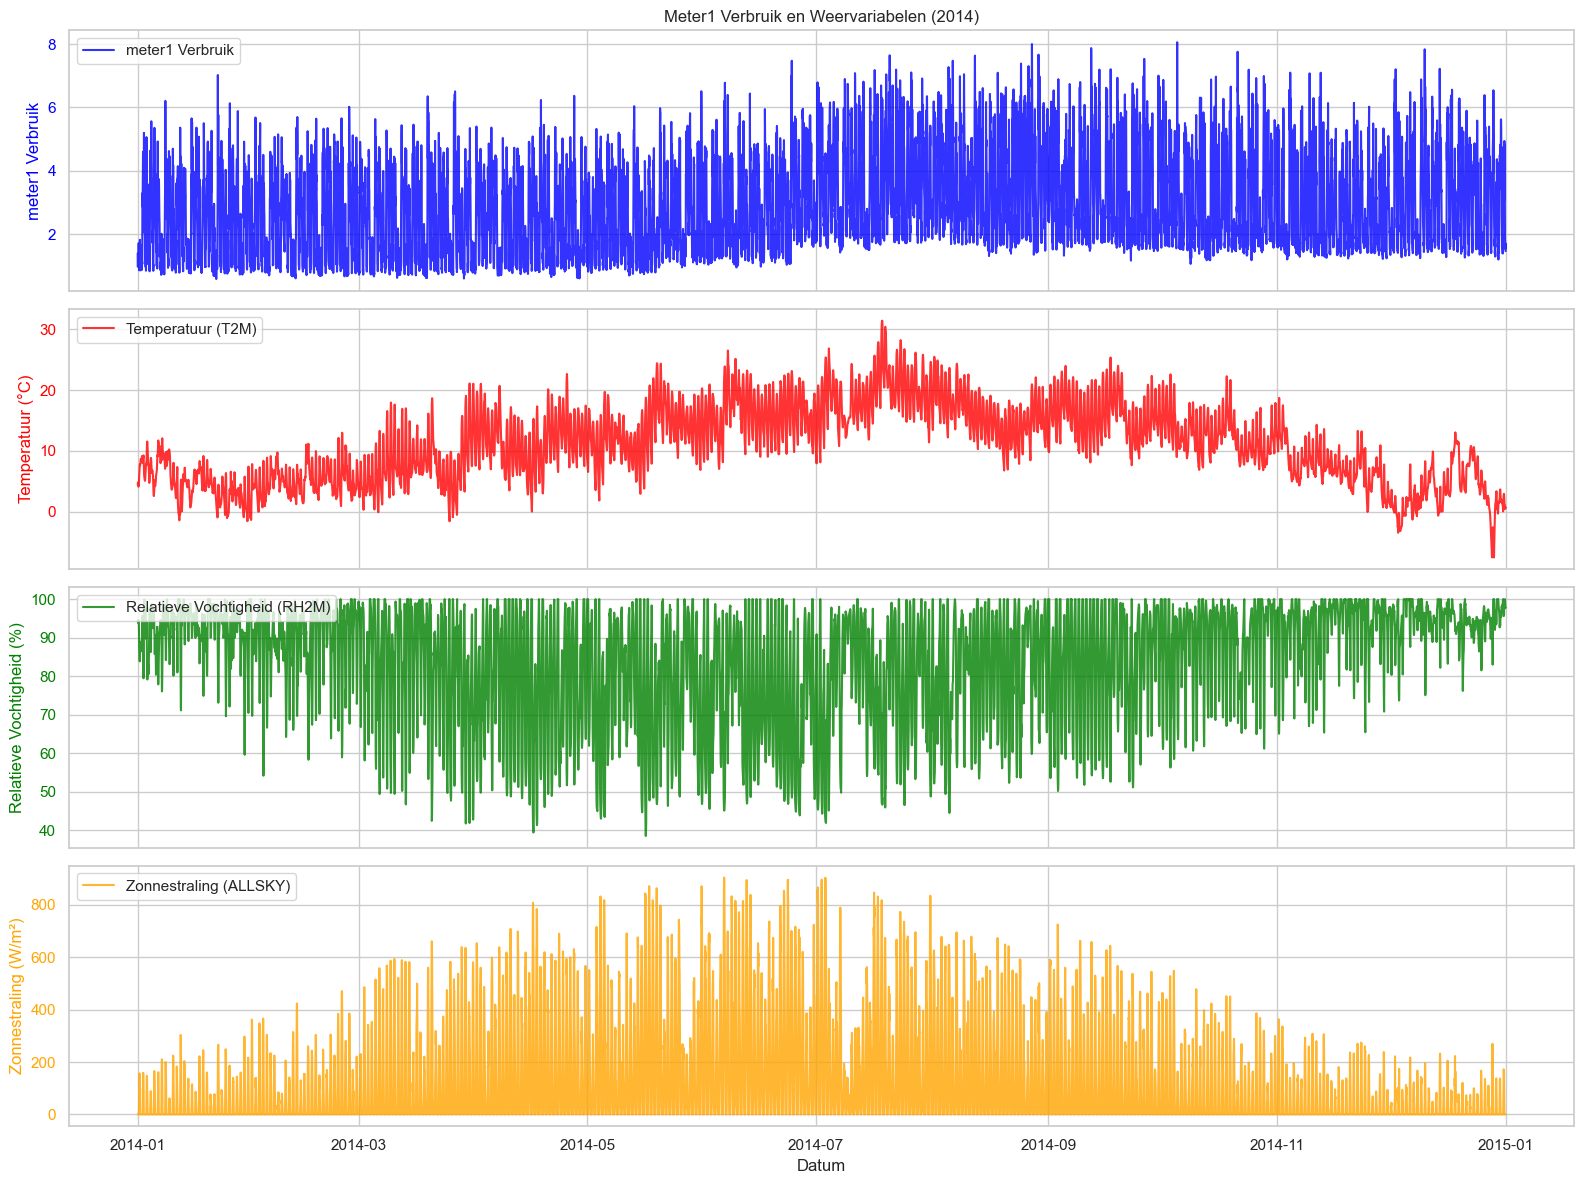

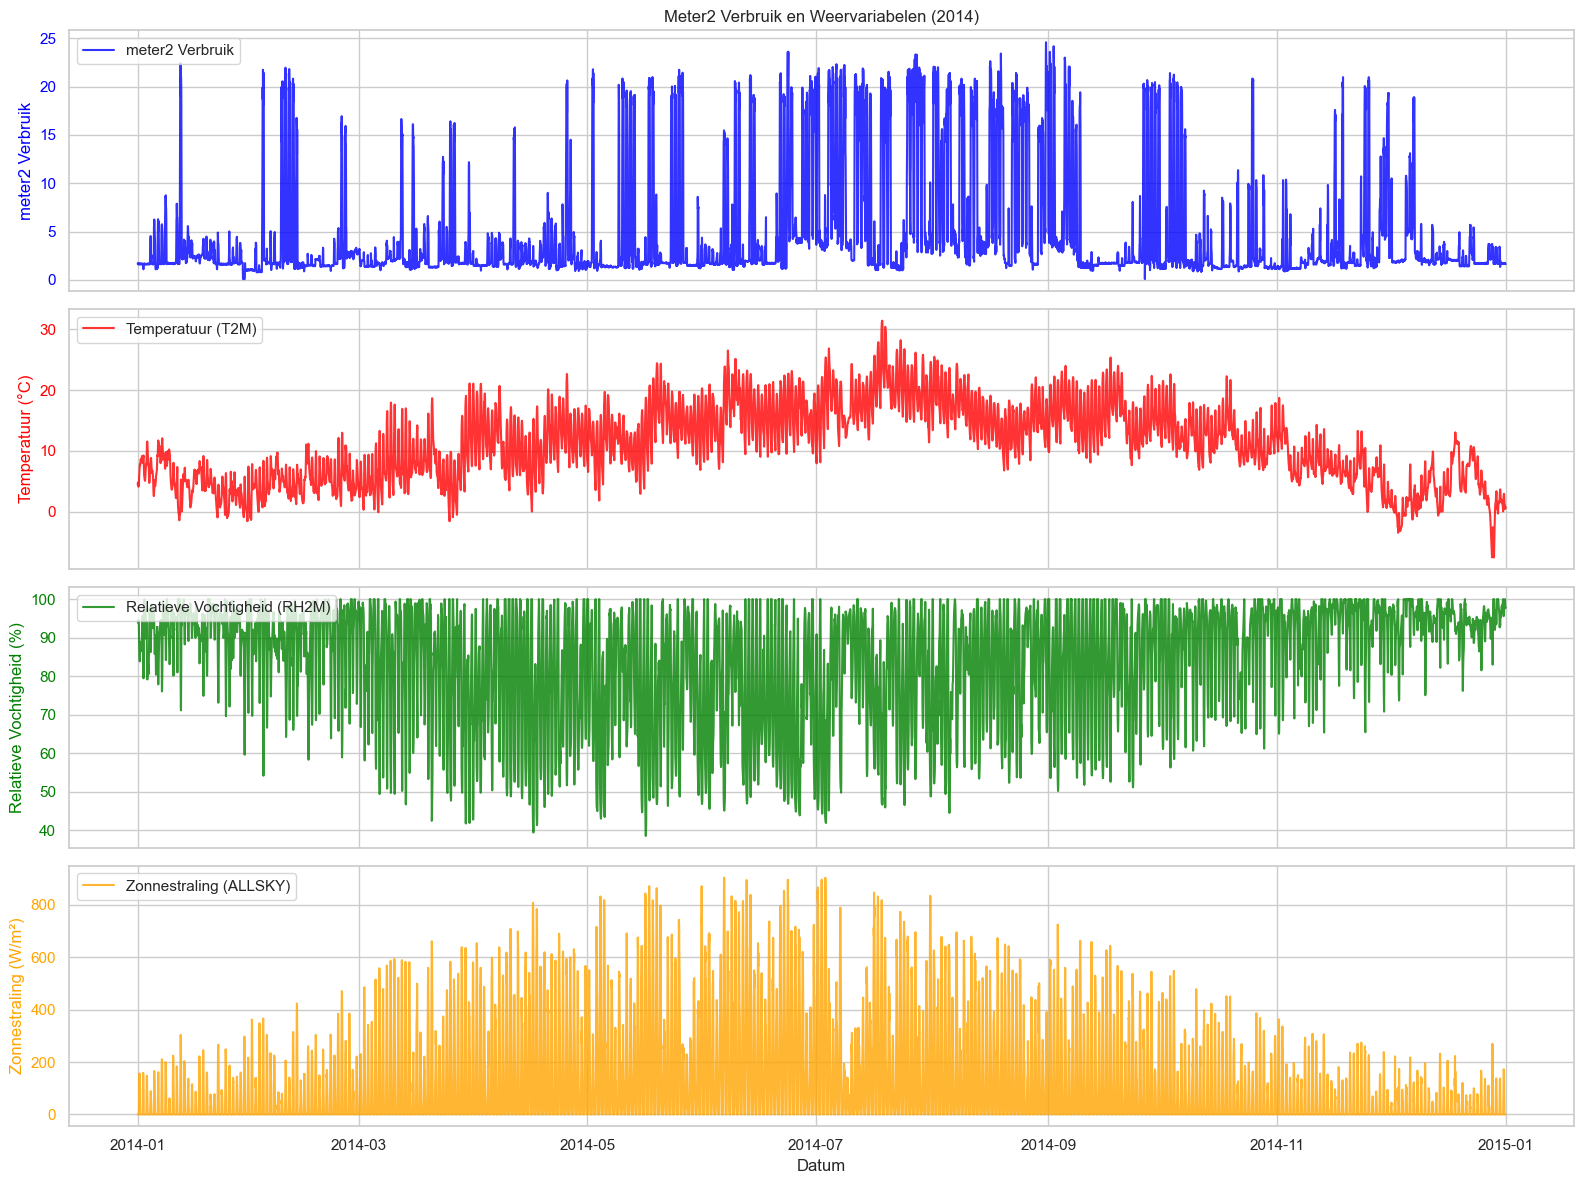

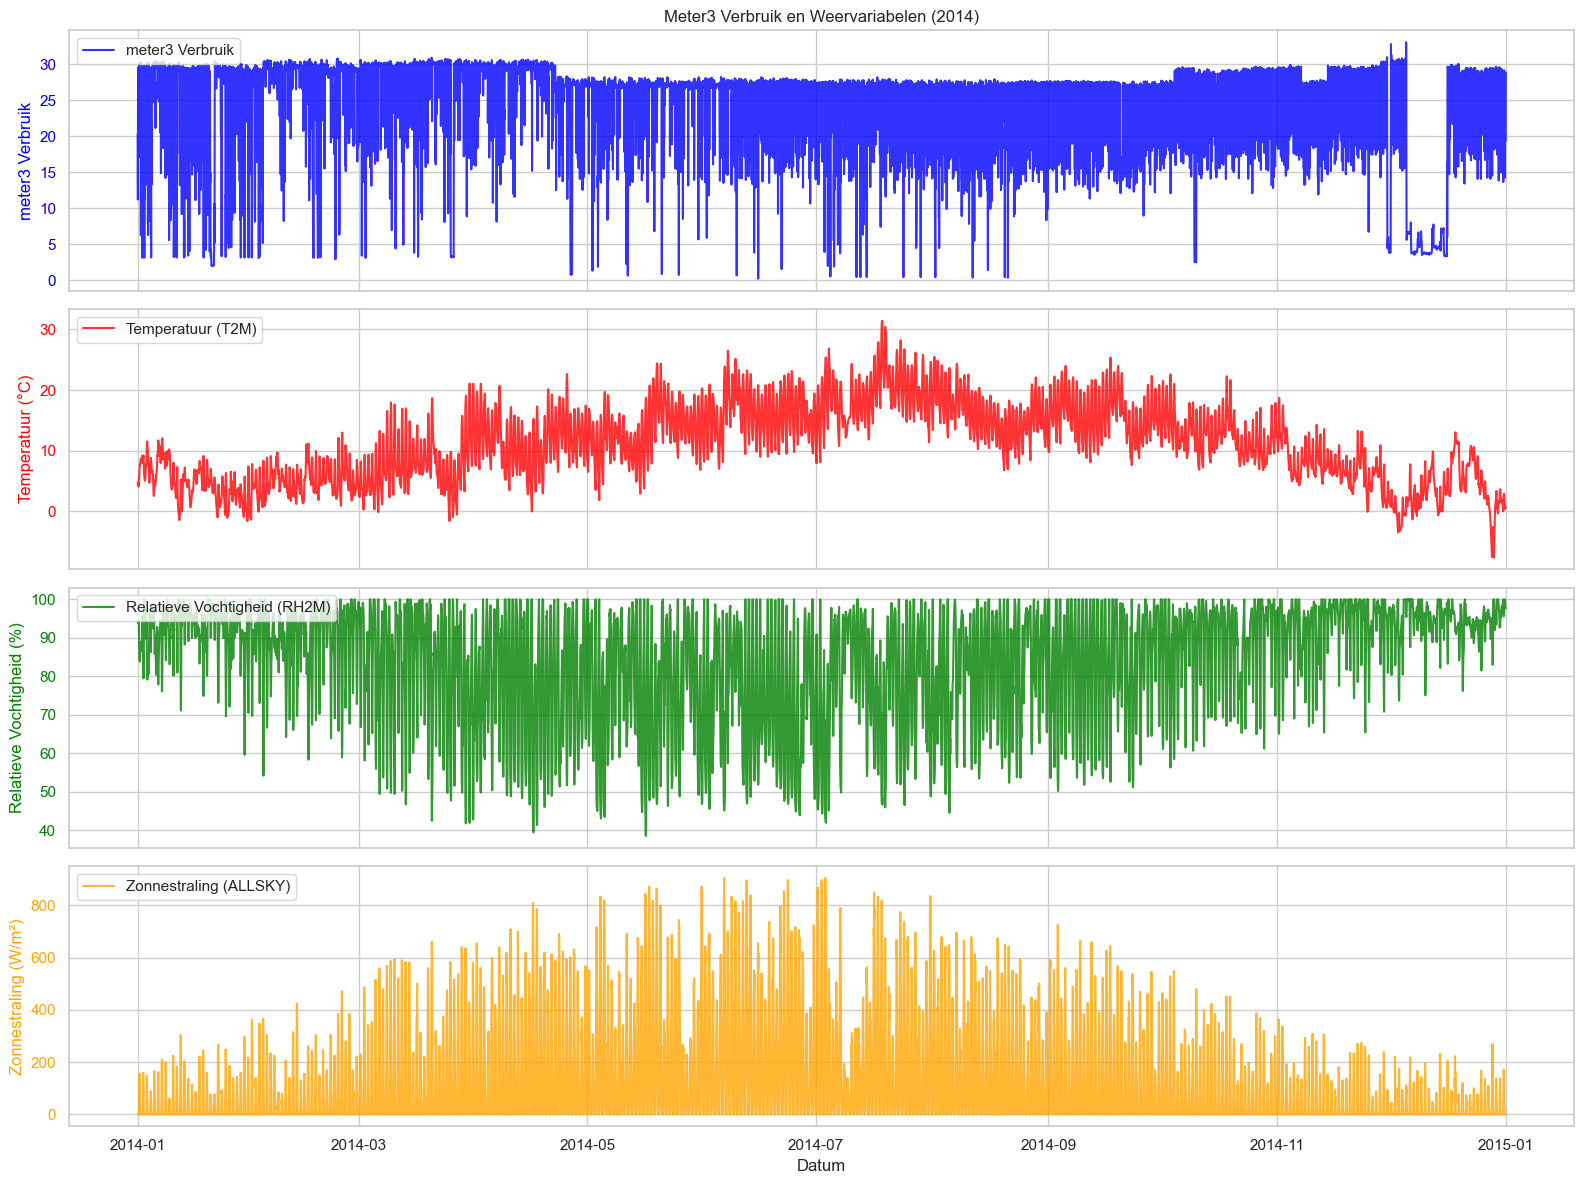

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_meter_with_weather_separated(df, meter_name, title):
    # Maak een figuur met subplots
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(16, 12), sharex=True)
    
    # Plot 1: Verbruik van de meter
    axes[0].plot(df['datetime'], df[meter_name], color='blue', alpha=0.8, label=f'{meter_name} Verbruik')
    axes[0].set_ylabel(f'{meter_name} Verbruik', color='blue')
    axes[0].tick_params(axis='y', labelcolor='blue')
    axes[0].legend(loc='upper left')
    axes[0].set_title(f'{title} en Weervariabelen (2014)')

    # Plot 2: Temperatuur (T2M)
    axes[1].plot(df['datetime'], df['T2M'], color='red', alpha=0.8, label='Temperatuur (T2M)')
    axes[1].set_ylabel('Temperatuur (°C)', color='red')
    axes[1].tick_params(axis='y', labelcolor='red')
    axes[1].legend(loc='upper left')

    # Plot 3: Relatieve Vochtigheid (RH2M)
    axes[2].plot(df['datetime'], df['RH2M'], color='green', alpha=0.8, label='Relatieve Vochtigheid (RH2M)')
    axes[2].set_ylabel('Relatieve Vochtigheid (%)', color='green')
    axes[2].tick_params(axis='y', labelcolor='green')
    axes[2].legend(loc='upper left')

    # Plot 4: Zonnestraling (ALLSKY_SFC_SW_DWN)
    axes[3].plot(df['datetime'], df['ALLSKY_SFC_SW_DWN'], color='orange', alpha=0.8, label='Zonnestraling (ALLSKY)')
    axes[3].set_ylabel('Zonnestraling (W/m²)', color='orange')
    axes[3].tick_params(axis='y', labelcolor='orange')
    axes[3].legend(loc='upper left')

    # Pas de layout aan
    plt.xlabel('Datum')
    plt.tight_layout()
    plt.show()

# Genereer plots voor elke meter
plot_meter_with_weather_separated(df_merged, 'meter1', 'Meter1 Verbruik')
plot_meter_with_weather_separated(df_merged, 'meter2', 'Meter2 Verbruik')
plot_meter_with_weather_separated(df_merged, 'meter3', 'Meter3 Verbruik')

je kan duidelijk zien dat uw verbruik zal stijgen/dalen naar gelang de zon uit zit/de vochtigheid en temperatuur.

## Antwoord je hypothese/vraag

- Er zullen significante verschillen zijn tussen de meters, wat kan wijzen op verschillende gebruikspatronen of apparatuur.
- Het energieverbruik zal hoger zijn in de wintermaanden vanwege verwarming en lagere temperaturen, en lager in de zomermaanden
- Er zal een seizoensgebonden trend zichtbaar zijn